# Project 4: Reinforcement Learning
### Train a Smartcab How to Drive
<sub>Uirá Caiado. Jul 7, 2016<sub>

#### Abstract

*A smartcab is a self-driving car from the not-so-distant future that ferries people from one arbitrary location to another. In this project, I will design the AI driving agent for the smartcab using reinforcement learning. This [area of machine learning](https://en.wikipedia.org/wiki/Reinforcement_learning) is inspired by behaviorist psychology and consists in training the agent by reward and punishment without needing to specify how the task is to be achieved. The agent should learn an optimal policy for driving on city roads, obeying traffic rules correctly, and trying to reach the destination within a goal time.*


## 1. Introduction

In this section, I will present a brief introduction to reinforcement learning and to the problem addressed by this project.


### 1.1. Reinforcement Learning

As explained by \cite{Mohri_2012}, reinforcement learning is the study of planning and learning in a scenario where a learner (or agent) actively interacts with the environment to achieve a particular goal. The achievement of the agent's goal is typically measured by the reward he receives from the environment and which he seeks to maximize.

\cite{Kaelbling_1996} state that the most significant difference between reinforcement learning and supervised learning is that there is no presentation of input/output pairs. Instead, they explained that after choosing an action, the agent is told the immediate reward and the following state, but is not told which action would have been in its best long-term interests. It is necessary for the agent to gather useful experience about the possible system states, actions, transitions and rewards actively to act optimally.

Defining a general formulation of the problem based on a Markov Decision Process (MDP), as proposed by \cite{Mitchell}, the agent can perceive a set $S$ os distinct states of its environment and has a set $A$ of actions that it can perform. So, at each discrete time step $t$, the agent senses the current state $s_t$ and choose to take an action $a_t$. The environment responds by providing the agent a reward $r_t=r(s_t, a_t)$ and by producing the succeeding state $s_{t+1}=\delta(s_t, a_t)$. The functions $r$ and $\delta$ only depend on the current state and action (it is [memoryless](https://en.wikipedia.org/wiki/Markov_process)), are part of the environment and are not necessarily known to the agent.

The task of the agent is to learn a policy $\pi$ that maps each state to an action ($\pi: S \rightarrow A$), selecting its next action $a_t$ based solely on the current observed state $s_t$, that is $\pi(s_t)=a_t$. The optimal policy, or control strategy, is the one that produces the greatest possible cumulative reward over time. So, stating that:

$$V^{\pi}(s_t)= r_t + \gamma r_{t+1} + \gamma^2 r_{t+1} + ... = \sum_{i=0}^{\infty} \gamma^{i} r_{t+i}$$

Where $V^{\pi}(s_t)$ is also called the discounted cumulative reward and it represents the cumulative value achieved by following an policy $\pi$ from an initial state $s_t$ and $\gamma \in [0, 1]$ is a constant that determines the relative value of delayed versus immediate rewards. If we set $\gamma=0$, only immediate rewards is considered. As $\gamma \rightarrow 1$, future rewards are given greater emphasis relative to immediate reward. The optimal policy $\pi^{*}$ that will maximizes $V^{\pi}(s_t)$ for all states $s$ can be written as:

$$\pi^{*} = \underset{\pi}{\arg \max} \, V^{\pi} (s)\,\,\,\,\,, \,\, \forall s$$

As learning $\pi^{*}: S \rightarrow A$ directly is difficult because the available training data does not provide training examples of the form $(s, a)$, in the section 4 I will implement the Q-learning algorithm for estimating the optimal policy.


### 1.2. What Will Be Done

The goal of this project is to design the AI driving agent for the smartcab that operates in an idealized grid-like city.

The smartcab is able to sense whether the traffic light is green for its direction of movement and whether there is a car at the intersection on each of the incoming roadways (and which direction they are trying to go). In addition to this, each trip has an associated timer that counts down every time step. If the timer is at $0$ and the destination has not been reached, the trip is over, and a new one may start.

It should receive the inputs mentioned above at each time step t, and generate an output move, that consists on to stay put at the current intersection, move one block forward, one block left, or one block right (no backward movement).

The smartcab also should receive a reward for each successfully completed trip. A trip is considered “successfully completed” if the passenger is dropped off at the desired destination within a pre-specified time bound. It also gets a smaller reward for each correct move executed at an intersection. It gets a minor penalty for a wrong move and a larger penalty for violating traffic rules and/or causing an accident.

Based on the rewards and penalties it gets, the agent should learn an optimal policy for driving on city roads, obeying traffic rules correctly, and trying to reach the destination within a goal time.

## 2. Implement a Basic Driving Agent

In this section, I will implement a basic driving agent that accepts specified inputs ans produces a valid output.

```
Udacity:

Implement the basic driving agent, which processes the following inputs at each time step:

Next waypoint location, relative to its current location and heading, Intersection state (traffic light and presence of cars), and, Current deadline value (time steps remaining), And produces some random move/action (None, 'forward', 'left', 'right'). Don’t try to implement the correct strategy! That’s exactly what your agent is supposed to learn.

Run this agent within the simulation environment with enforce_deadline set to False (see run function in agent.py), and observe how it performs. In this mode, the agent is given unlimited time to reach the destination. The current state, action taken by your agent and reward/penalty earned are shown in the simulator.

In your report, mention what you see in the agent’s behavior. Does it eventually make it to the target location?


It is asked to:

- Agent accepts inputs: Student is able to implement the desired interface to the agent that accepts specified inputs.
- Produces a valid output: The driving agent produces a valid output (one of None, ‘forward’, ‘left’, ‘right’) in response to the inputs.
- Runs in simulator: The driving agent runs in the simulator without errors. Rewards and penalties do not matter - it’s okay for the agent to make mistakes.
```


### 2.1. My Grid-Like World

Let's start by testing the output produced by my current *world*, that will be used to analyze the results of this project. This *world* is a grid-like city, with roads going North-South and East-West. Other vehicles may be present on the streets, but no pedestrians. There is a traffic light at each intersection that can be in one of two states: North-South open or East-West open. US right-of-way rules apply: On a green light, you can turn left only if there is no oncoming traffic at the intersection coming straight. On a red light, you can turn right if there is no oncoming traffic turning left or traffic from the left going straight.

We are told to assume that a higher-level planner assigns a route to the smartcab, splitting it into waypoints at each intersection. The time in this world is quantized and at any instant, the smartcab is at some intersection. Therefore, the next waypoint is always either one block straight ahead, one block left, one block right, one block back or exactly there (reached the destination). Below is a sample of the log file generated by the simulator.

In [3]:
import random
from smartcab.environment import Agent, Environment
from smartcab.planner import RoutePlanner
from smartcab.simulator import Simulator
import smartcab.agent as agent; reload(agent);

In [16]:
e = Environment()  # create environment (also adds some dummy traffic)
a = e.create_agent(agent.LearningAgent)  # create agent
e.set_primary_agent(a, enforce_deadline=True)  # specify agent to track
sim = Simulator(e, update_delay=0.5, display=False)

In [17]:
# this test was performed before I implement the codes
sim.run(n_trials=1)

Simulator.run(): Trial 0
2016-07-16 16:29:32,947;Environment.reset(): Trial set up with start = (5, 2), destination = (2, 4), deadline = 25
2016-07-16 16:29:32,960;RoutePlanner.route_to(): destination = (2, 4)
2016-07-16 16:29:33,466;LearningAgent.update(): deadline = 25, inputs = {'light': 'red', 'oncoming': None, 'right': None, 'left': None}, action = None, reward = 0.0
2016-07-16 16:29:33,966;LearningAgent.update(): deadline = 24, inputs = {'light': 'red', 'oncoming': None, 'right': None, 'left': None}, action = None, reward = 0.0
2016-07-16 16:29:34,466;LearningAgent.update(): deadline = 23, inputs = {'light': 'red', 'oncoming': None, 'right': None, 'left': None}, action = None, reward = 0.0
2016-07-16 16:29:34,966;LearningAgent.update(): deadline = 22, inputs = {'light': 'red', 'oncoming': None, 'right': 'forward', 'left': None}, action = None, reward = 0.0
2016-07-16 16:29:35,466;LearningAgent.update(): deadline = 21, inputs = {'light': 'green', 'oncoming': None, 'right': 'forwar

### 2.3. The Basic Agent

As mentioned before, I am going to implement a smartcab that processes the following inputs at each time step:

- *Next waypoint location*: about its current position and heading
- *Intersection state*: traffic light and presence of cars
- *Current deadline value*: time steps remaining

For the purposes of this project, the first implementation of the agent should produce just some random move at each time $t$, such that $a_t \in (None,\, forward,\, left,\, right)$. I will not implement the correct strategy because it is precisely what my agent is supposed to learn. Below I am going to simulate $100$ different trials with the `enforce_deadline` set to False and will save the logs produced by the agent to observe how it performs. In this mode, the agent is given unlimited time to reach the destination.

In [34]:
import smartcab.eda as eda; reload(eda);
s_fname = 'log/sim_Mon_Jul_18_003801_2016.txt'
l_aux, t_aux = eda.simple_counts(s_fname)

Number of Trials: 100
Times that the agent reached the target location: 69
Times the agent reached the hard deadline: 31
Times the agent SUCCESSFULLY reached the target location: 21
Counting of moves made:
{'forward': 2018, 'None': 2085, 'right': 2035, 'left': 2094}


As can be seen above, even using just random moves, the agent still was able to reach the target destination roughly $20\%$ of the trials at the deadline stipulated by the Planner. If we considering all the times it reached the location, it was able to complete the route almost $70\%$ of the trials. Now, I am going to produce same basic statistics about the times that it reached the target location.

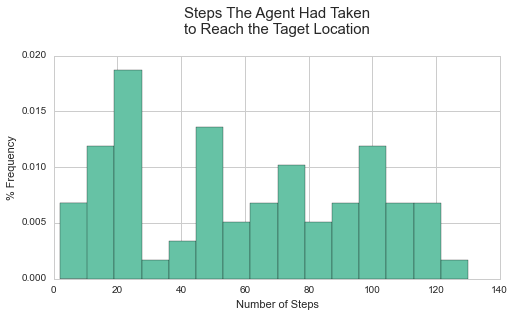

In [30]:
import pandas as pd
df_last = pd.DataFrame(l_last)
ax = (df_last.ix[df_last.success==1, 'steps']).hist(bins=15, normed=True)
ax.set_title("Steps The Agent Had Taken\nto Reach the Taget Location\n", fontsize=15);
ax.set_ylabel("% Frequency")
ax.set_xlabel("Number of Steps");

In [31]:
df_count = pd.DataFrame(df_last.ix[df_last.success==1, 'steps'])
df_count.columns = ["Number Of Steps"]
df_count.describe()

,Number Of Steps
count,69.000000
mean,59.884058
std,36.539880
min,2.000000
25%,24.000000
50%,60.000000
75%,91.000000
max,130.000000


It took 59 steps on average, and the variation was huge. The agent has taken from 2 steps to 130 to finish the route. In the section 4, I will try to improve that.

### 2.4. Identify and Update State

```
Udacity:

It is asked to:

- Reasonable states identified: Student has identified states that model the driving agent and environment, along with a sound justification. Justify why you picked these set of states, and how they model the agent and its environment.
-  Agent updates state: The driving agent updates its state when running, based on current input. The exact state does not matter, and need not be correlated with inputs, but it should change during a run.
```

---> put the old text here


To complete the implementation of my Basic Agent, I still need to decide how it will represent its state internally. Considering the inputs that it receives before performs any action and, consequently, receives a reward, I will use two of them in a tuple to represent the current state of my agent, in the form $(inputs,\, next\_waypoint)$. $Inputs$ is a dictionary with the state of the traffic light for the agents' direction of movement and the direction of the random agents on each of the incoming roadways (if any) and $next\_waypoint$ is the direction of the target location. As suggested by the reviewers, I am not using $dead\_line$ due to the number of states it can take. As we will see in the next section, one of the requirements of algorithm used in this project to work properly is that it visits every possible state-action pair many times as possible. I believe that this state will represent a reasonable set of states that my agent could learn over a hundred trials. So, let's count the number of states that I get when I enforce deadline in my simulation on $100$ trials.

In [7]:
s_fname = 'log/sim_Mon_Aug__1_115005_2016.log'
from collections import defaultdict
d_count = defaultdict(int)

with open(s_fname) as fr:
    set_states = set()
    for idx, row in enumerate(fr):
        s_aux = row.strip().split(';')[1]
        if 'LearningAgent.update' in s_aux:
            f_aux, l_aux = s_aux[24:].split('action = ')
            state = f_aux.strip() + ','.join(l_aux.split(",")[1:])
            d_count[state] += 1
            
print 'number of states in the state space: {}'.format(len(d_count))

number of states in the state space: 880


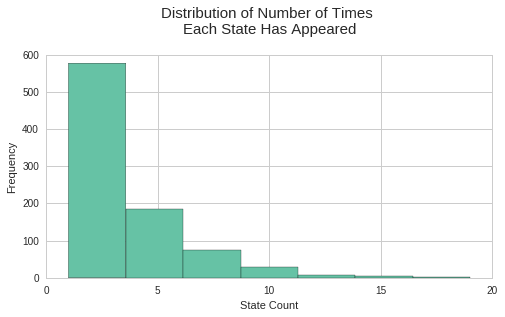

In [8]:
import pandas as pd
ax = pd.Series(d_count.values()).hist(bins=7)
ax.set_xlabel("State Count")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of Number of Times \nEach State Has Appeared\n", fontsize=15);

The figure above presents the frequency of the counting of each state. For instance, around $600$ states appeared just two times, more than $100$ appeared four times and so on. Curious the agent's behavior distribution looks like a log-normal distribution.

## 3. Implement Q-Learning

In this section, I will briefelly explained the concept of Q-learning and implement an algorithm to learn the Q function.


### 3.1. The Q-Function

As mention before, to learn an optimal policy $\pi^{*}$, I can't learn a function $\pi^{*}: S \rightarrow A$ that maps a state to the optimal action directly. There is no such information upfront to be used as training data. Instead, as \cite{Mitchell} explained, the only available information is the sequence of immediate rewards $r(s_i, a_i)$ for $i=1,\, 2,\, 3,\,...$

So, as we are trying to maximize the cumulative rewards $V^{*}(s_t)$ for all states $s$, the agent should prefer $s_1$ over $s_2$ wherever $V^{*}(s_1) > V^{*}(s_2)$. Given that the agent must choose among actions and not states, and it isn't able to perfectly predict the immediate reward and immediate successor for every possible state-action transition, we also must learn $V^{*}$ indirectly.

To solve that, we define a function $Q(s, \, a)$ such that its value is the maximum discounted cumulative reward that can be achieved starting from state $s$ and applying action $a$ as the first action. So, we can write:

$$Q(s, \, a) = r(s, a) + \gamma V^{*}(\delta(s, a))$$

As $\delta(s, a)$ is the state resulting from applying action $a$ to state $s$ (the successor) chosen by following the optimal policy, $V^{*}$ is the cumulative value of the immediate successor state discounted by a factor $\gamma$. Thus,  what we are trying to achieve is

$$\pi^{*}(s) = \underset{a}{\arg \max} Q(s, \, a)$$

Thus, the optimal policy can be obtained even if the agent just uses the current action $a$ and state $s$ and chooses the action that maximizes $Q(s,\, a)$. Also, it is important to notice that the function above implies that the agent can select optimal actions even when it has no knowledge of the functions $r$ and $\delta$. In the next subsection, we will see how \cite{Mitchell} defined a reliable way to estimate training values for $Q$, given only a sequence of immediate rewards $r$.


### 3.2. Learning $Q$

As we have seen, learning the Q function corresponds to learning the optimal policy. According to \cite{Mohri_2012}, the optimal state-action value function $Q^{*}$ is defined for all $(s, \, a) \in S \times A$ as the expected return for taking the action $a \in A$ at the state $s \in S$, following the optimal policy. So, it can be written as \cite{Mitchell} suggested:

$$V^{*}(s) = \underset{a'}{\arg \max} Q(s, \, a')$$

Using this relationship, we can write a recursive definition of Q function, such that:

$$Q(s, \, a) = r(s, a) + \gamma \, \underset{a'}{\max} \, Q(\delta(s,\, a), \, a')$$

The recursive nature of the function above implies that our agent doesn't know the actual $Q$ function. It just can estimate $Q$, that we will refer as $\hat{Q}$. It will represents is hypothesis $\hat{Q}$ as a large table that attributes each pair $(s\, , \, a)$ to a value for $\hat{Q}(s,\, a)$ - the current hypothesis about the actual but unknown value $Q(s, \, a)$. I will initialize this table with zeros, but it could be filled with random numbers, according to \cite{Mitchell}. Still according to him, the agent repeatedly should observe its current state $s$ and do the following:
- Observe the current state $s$ and:
    - Choose some action $a$ and execute it
    - Receive the immediate reward $r = r(s, a)$
    - initialize the table entry $\hat{Q}(s, \, a)$ to zero if there is no entry $(s, \, a)$
    - Observe the new state $s' = \delta(s, \,a)$. 
    - Updates the table entry for $\hat{Q}(s, \, a)$ following:
        - $\hat{Q}(s, \, a) \leftarrow r + \gamma \underset{a'}{\max} \hat{Q}(s', \, a')$
- $s \leftarrow s'$
    
Note this training rule is suited to a deterministic Markov decision process (where $r(s,\, a)$ and $\delta(s,\, a)$ are deterministics) and uses the agent's current $\hat{Q}$ values for the new state $s'$ to refine its estimate of $\hat{Q}(s, \,a)$ for the previous state $s$. It is tricky. So, let's take a look at its performance.

```
Udacity:

It is asked to:

- Agent updates Q-values: The driving agent updates a table/mapping of Q-values correctly, implementing the Q-Learning algorithm.
- Picks the best action: Given the current set of Q-values for a state, it picks the best available action.
- Changes in behavior explained: Student has reported the changes in behavior observed, and provided a reasonable explanation for them. What changes do you notice in the agent’s behavior?
```

In [38]:
import smartcab.eda as eda; reload(eda)
s_fname = 'log/sim_Tue_Aug__2_030138_2016.log'
l_aux, t_aux = eda.simple_counts(s_fname)

Number of Trials: 100
Times that the agent reached the target location: 93
Times the agent reached the hard deadline: 7
Times the agent SUCCESSFULLY reached the target location: 93
Counting of moves made:
{'forward': 393, 'None': 316, 'right': 624, 'left': 217}


In [83]:
import smartcab.eda as eda; reload(eda)
s_fname = 'log/sim_Mon_Jul_25_015925_2016.txt'
l_aux, t_aux = eda.simple_counts(s_fname)

Number of Trials: 100
Times that the agent reached the target location: 55
Times the agent reached the hard deadline: 45
Times the agent SUCCESSFULLY reached the target location: 55
Counting of moves made:
{'forward': 486, 'None': 411, 'right': 857, 'left': 463}


The agent is reaching its destination much more frequently than before. When the agent selected its action randomly, it reached its destination just 21% of the times. Now, it is reaching 55%. Now the agent is always taking the "safest action":  takes the action with the biggest reward. It is not bad, but looking at the number of explored actions by state in the Q-table produced by this simulation, we can notice something curious

In [39]:

df_q_table = pd.read_csv('log/qtable.log', sep='\t')
df_count = pd.DataFrame(4 - ((df_q_table.isnull())).sum(axis=1))
df_count.columns= ['Number of Explored Actions'] 
df_count['count'] = 1
df_grouped = df_count.groupby('Number of Explored Actions').sum()
df_grouped = df_grouped * 1. / df_grouped.sum()
df_grouped

,count
Number of Explored Actions,
1,0.571429
2,0.285714
3,0.057143
4,0.085714


In [11]:
df_q_table = pd.read_csv('log/qtable2.txt', sep='\t')
df_count = pd.DataFrame(4 - ((df_q_table.isnull())).sum(axis=1))
df_count.columns= ['Number of Explored Actions'] 
df_count['count'] = 1
df_grouped = df_count.groupby('Number of Explored Actions').sum()
df_grouped = df_grouped * 1. / df_grouped.sum()
df_grouped

,count
Number of Explored Actions,
1,0.673913
2,0.173913
3,0.086957
4,0.065217


In [100]:
df_q_table = pd.read_csv('log/qtable.txt', sep='\t')
df_count = pd.DataFrame(4 - ((df_q_table.isnull())).sum(axis=1))
df_count.columns= ['Number of Explored Actions'] 
df_count['count'] = 1
df_grouped = df_count.groupby('Number of Explored Actions').sum()
df_grouped = df_grouped * 1. / df_grouped.sum()
df_grouped

,count
Number of Explored Actions,
1,0.562814
2,0.211055
3,0.158291
4,0.067839


The agent explored just one possible action in $56\%$ of the states in the Q-Table. According to \cite{Mitchell}, there are some conditions to ensure that the algorithm converges toward a $\hat{Q}$ equal to the true $Q$ function. One of them is that the system should be a deterministic MDP. Another is that the agent must select actions in a way that it visits every possible state-action pair infinitely often. Looking at the number of times this implementation of the agent explored all $4$ possibles actions (less than $7\%$ of the states), I would say that it isn't true. In the next section, I will try to improve te agent's performance.

## 4. Enhance the Driving Agent

In this section, I will try to improve the driving agent to make it consistently reaches the destination within allotted time and the net reward positive.
```
Udacity:

It is asked to:
- Improvements reported: Specific improvements made by the student beyond the basic Q-Learning implementation have been reported, including at least one parameter that was tuned along with the values tested. The corresponding results for each value are also reported.
- Agent learns a feasible policy within 100 trials: The driving agent is able to consistently reach the destination within allotted time, with net reward remaining positive.
```

### 4.1. Experimentation Strategies

One of the issues of the current strategy is that the agent could overcommit to actions that presented positive $\hat{Q}$ values early in the simulation, failing to explore other actions that could present even higher values. \cite{Mitchell} proposed to use a probabilistic approach to select actions, assigning higher probabilities to action with high $\hat{Q}$ values, but given to every action at least a nonzero probability. So, I will implement the following relation:

$$P(a_i\, | \,s ) = \frac{k ^{\hat{Q}(s, a_i)}}{\sum_j k^{\hat{Q}(s, a_j)}}$$

Where $P(a_i\, | \,s )$ is the probability of selecting the action $a_i$ given the state $s$. The constant $k$ is positive and determines how strongly the selection favors action with high $\hat{Q}$ values. Let's look at the number of times the algorithm choose to explore when we vary the value of the $k$.

In [5]:
import smartcab.eda as eda; reload(eda);
import pandas as pd

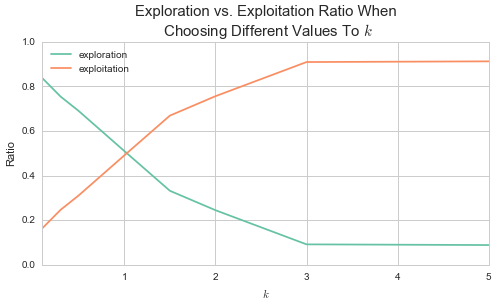

In [32]:
s_fname = 'log/sim_Tue_Aug__2_024954_2016.log'
d1, d2, d3 = eda.performance_measures(s_fname)
df_plot = pd.DataFrame(d1) * 1.
df_plot.index = [u'exploration', u'exploitation']
ax = (df_plot / df_plot.sum()).T.plot()
ax.set_xlabel('$k$')
ax.set_ylabel('Ratio')
ax.set_title('Exploration vs. Exploitation Ratio When\n Choosing Different Values To $k$',
             fontsize=15);

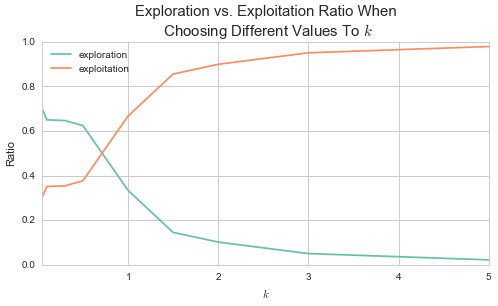

In [487]:
s_fname = 'log/sim_Tue_Jul_26_221055_2016.txt'
d1, d2, d3 = eda.performance_measures(s_fname)
df_plot = pd.DataFrame(d1) * 1.
df_plot.index = [u'exploration', u'exploitation']
ax = (df_plot / df_plot.sum()).T.plot()
ax.set_xlabel('$k$')
ax.set_ylabel('Ratio')
ax.set_title('Exploration vs. Exploitation Ratio When\n Choosing Different Values To $k$',
             fontsize=15);

As can be seen above, large values of $k$ assigned a higher probability of the agent exploits what it already has learned. Small values have made the agent favor the exploration of new actions. Now, let's see how the different values of $k$ impacted on the times the agent completed the routes.

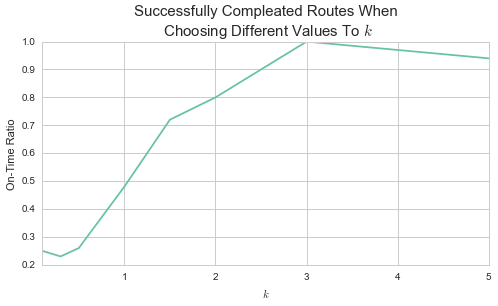

In [33]:
ax = pd.Series(d3).plot()
ax.set_xlabel('$k$')
ax.set_ylabel('On-Time Ratio')
ax.set_title('Successfully Compleated Routes When\n Choosing Different Values To $k$',
             fontsize=15);

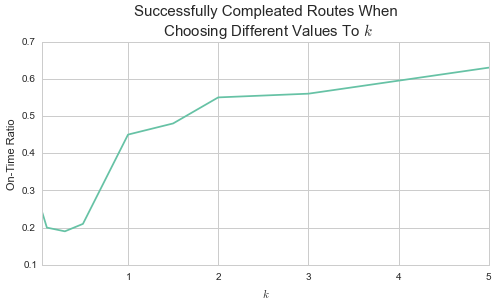

In [482]:
ax = pd.Series(d3).plot()
ax.set_xlabel('$k$')
ax.set_ylabel('On-Time Ratio')
ax.set_title('Successfully Compleated Routes When\n Choosing Different Values To $k$',
             fontsize=15);

The agent presented a very steep improvement as $k$ was approaching $2$. Above this value, the completed trips ratio just showed a slight growth. Now, let's check how the number of trials changed the average reward received by the agent.

In [16]:
import matplotlib.pyplot as plt

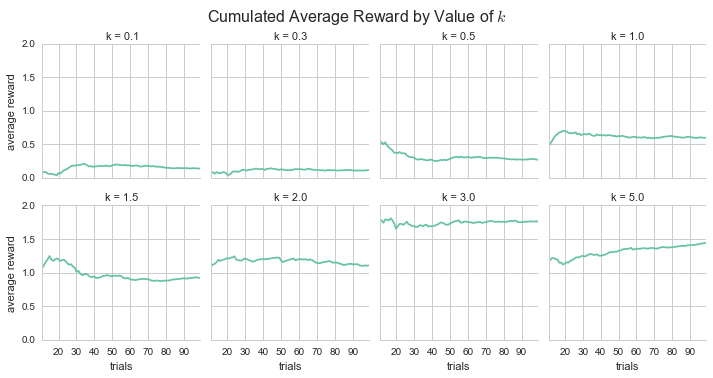

In [34]:
df_plot = pd.DataFrame(d2).iloc[10:, :]
df_plot = df_plot.unstack().reset_index()
df_plot.columns = ['k', 'trials', 'average reward']

def dateplot(x, y, **kwargs):
    ax = plt.gca()
    data = kwargs.pop("data")
    data.plot(x=x, y=y, ax=ax, **kwargs)

g = sns.FacetGrid(df_plot, col="k", col_wrap=4, size=2.5)
g = g.map_dataframe(dateplot, "trials", "average reward")
g.fig.suptitle("Cumulated Average Reward by Value of $k$",
               fontsize=16, y=1.04);

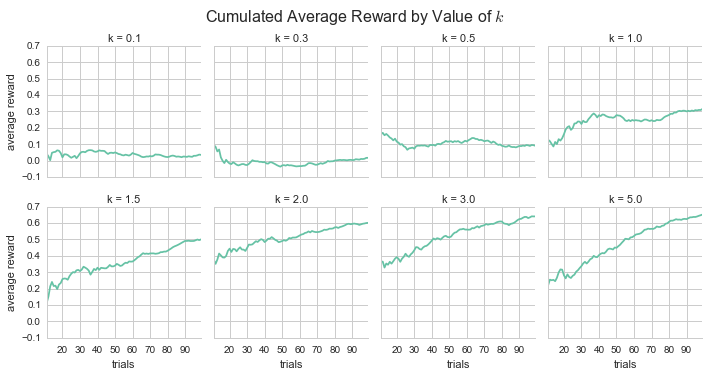

In [483]:
df_plot = pd.DataFrame(d2).iloc[10:, 1:]
df_plot = df_plot.unstack().reset_index()
df_plot.columns = ['k', 'trials', 'average reward']

def dateplot(x, y, **kwargs):
    ax = plt.gca()
    data = kwargs.pop("data")
    data.plot(x=x, y=y, ax=ax, **kwargs)

g = sns.FacetGrid(df_plot, col="k", col_wrap=4, size=2.5)
g = g.map_dataframe(dateplot, "trials", "average reward")
g.fig.suptitle("Cumulated Average Reward by Value of $k$",
               fontsize=16, y=1.04);

Clearly, small values of $k$ are worst than large values. As I want that my agent has some probability of exploring new actions, and it seems that $k=2$ is the best choice (the "slope" is not so steep, and the start value is pretty high), I will use this parameter to perform the next simulations.

### 4.2. Nondeterministic Rewards and Actions

The last modification that I want to introduce is when the environment is non-deterministic. As I said before, the algorithm used is appropriate to the deterministic case. On a nondeterministic environment, the reward function $r(s,\,a)$ and action transition function $\delta(s,\,a)$ may have probabilistic outcomes. As there are other agents in the smartcab world, I believe that it is a proper assumption.

As explained by \cite{Mitchell}, to handle nondeterministic MDPs, it is needed to redefine the value $V^{*}$ to be expressed as a expected value. So, jumping to the $Q$ function, we can re-express $Q$ recursively as:

\begin{equation}
\begin{aligned}
Q(s, \, a) &= E \left [r(s, a) \right ] + E \left [\gamma \, \underset{a'}{\max} \, Q(\delta(s,\, a), \, a')\right ]\\
&= E \left [r(s, a) \right ] + \gamma \,  E \left [\underset{a'}{\max} \, Q(\delta(s,\, a), \, a')\right ]\\
&= E \left [r(s, a) \right ] + \gamma \,  \sum_{s'} P\left(s' \,| \,s, a   \right) \underset{a'}{\max} \, Q(\delta(s,\, a), \, a')
\end{aligned}
\end{equation}


Where $P\left(s' \,| \,s, a   \right)$ is the probability that taking action $a$ in state $s$ will produce the next state $s'$. To implement that, we need to assume that the $\hat{Q}$ values in our table may be wrong, due to the nondeterministic behavior of our environment. So, \cite{Mitchell} suggested to modifying the training rule by introducing a decaying weighted average factor to the current $\hat{Q}$ value and to the revised estimate, such that:

$$\hat{Q}(s, \, a) \leftarrow  (1 - \alpha_{n})\, \hat{Q}_{n-1}(s, \, a) +  \alpha_{n}\left[ r + \gamma \underset{a'}{\max} \hat{Q}_{n-1}(s', \, a') \right ]$$

Where $\alpha_{n} = \frac{1}{1 + visits_{n}(s, \,a)}$ is the decaying factor and $visits_{n}$ is the total number of times this state-action $(s, \, a)$ pair has been visited. So, let's put it in practice.


In [37]:
import smartcab.eda as eda; reload(eda)
s_fname = 'log/sim_Tue_Aug__2_025938_2016.log'
d1, d2, d3 = eda.performance_measures(s_fname)
l_aux, t_aux = eda.simple_counts(s_fname)

Number of Trials: 100
Times that the agent reached the target location: 89
Times the agent reached the hard deadline: 11
Times the agent SUCCESSFULLY reached the target location: 89
Counting of moves made:
{'forward': 403, 'None': 103, 'right': 935, 'left': 286}


In [27]:
import smartcab.eda as eda; reload(eda)
s_fname = 'log/sim_Tue_Aug__2_022204_2016.log'
d1, d2, d3 = eda.performance_measures(s_fname)
l_aux, t_aux = eda.simple_counts(s_fname)

Number of Trials: 100
Times that the agent reached the target location: 76
Times the agent reached the hard deadline: 24
Times the agent SUCCESSFULLY reached the target location: 76
Counting of moves made:
{'forward': 471, 'None': 650, 'right': 542, 'left': 306}


In [45]:
import smartcab.eda as eda; reload(eda)
s_fname = 'log/sim_Fri_Jul_29_180801_2016.txt'
d1, d2, d3 = eda.performance_measures(s_fname)
l_aux, t_aux = eda.simple_counts(s_fname)

Number of Trials: 100
Times that the agent reached the target location: 58
Times the agent reached the hard deadline: 42
Times the agent SUCCESSFULLY reached the target location: 58
Counting of moves made:
{'forward': 550, 'None': 542, 'right': 887, 'left': 458}


Looking just at the times the agent has completed the route, it doesn't look like we made much progress. I will compare the performance of all the agents created so far in the last section.

### 4.3. The last parameter to Tune: Gamma

There is just one remain parameter of the model that was not explored yet:  the $\gamma$. As already explained, the $\gamma$ in the $\hat{Q}$ function is a factor used to discount the immediate successor state to be used to update $\hat{Q}$ table. As $\gamma$ approaches $0$, less "memory" the agent has. So, let's check what happens when we vary this parameter about the average cumulative reward of the learning agent:

In [12]:
s_fname = 'log/sim_Fri_Jul_29_190635_2016.txt'
d2, d3 = eda.performance_measures_gamma(s_fname)

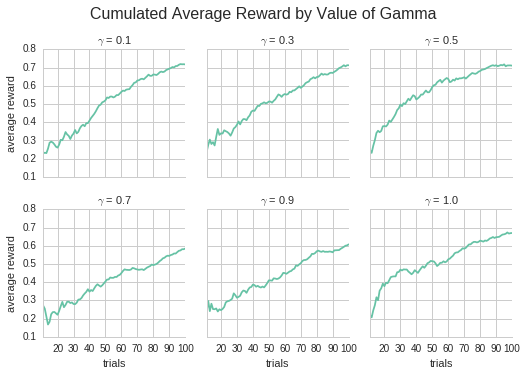

In [75]:
df_plot = pd.DataFrame(d2).iloc[10:, :]
df_plot = df_plot.unstack().reset_index()
df_plot.columns = ['$\gamma$', 'trials', 'average reward']

def dateplot(x, y, **kwargs):
    ax = plt.gca()
    data = kwargs.pop("data")
    data.plot(x=x, y=y, ax=ax, **kwargs)

g = sns.FacetGrid(df_plot, col="$\gamma$", col_wrap=3, size=2.5)
g = g.map_dataframe(dateplot, "trials", "average reward")
g.fig.suptitle("Cumulated Average Reward by Value of Gamma",
               fontsize=16, y=1.04);

In the last section, I will use $\gamma = 0.5$ to perform the final tests.

### 4.4. What Else We Can "Tune" ?  The Intern State

```
Udacity reviewer:

Can you briefly provide some further justification here as to why each of these input variables are necessary for learning the surrounding environment and traffic laws by observing numerous variation of the environment at each intersection? Also, if a specific input is omitted, please include some discussion as to why. Likewise, can you explain whether or not deadline is necessary for the state space? For instance, due to the number of states that the deadline variable can take, will it blow up our state space into a size that cannot be feasibly explored by the agent in 100 trials if included? Keep in mind that there would be too many states here for the agent to be able to visit and in order to learn the value of each action, your agent will need to visit every state many times over.
```

## 6. Conclusion

```
Udacity:

It is asked to:
- Final agent performance discussed: A description is provided of what an ideal or optimal policy would be. The performance of the final driving agent is discussed and compared to how close it is to learning the stated optimal policy. Report what changes you made to your basic implementation of Q-Learning to achieve the final version of the agent. How well does it perform? Does your agent get close to finding an optimal policy, i.e. reach the destination in the minimum possible time, and not incur any penalties?
```

The goal of the whole project was to build an agent that obeys traffic rules correctly and reachs the destination within an allotted time. So, the "perfect" agent would be the one that always come to the destination in the goal time without any penalty. 

However, as our environment is non-deterministic, to always reach the destination on time is not reasonable. Also, as the environment penalizes the agent even when it makes a correct move, but in a distinct direction from the target location, it isn't fair to expect that the perfect agent never incurs any penalty.

So, the best one would be the one that learns a reasonable policy fast and receives the maximum average cumulative reward possible. Average because we should weight the rewards received by the number of steps used to avoid discrepancies. In this sense, let's first compare how the modifications made on this project reflected on our agent when we ensure deadline. The improved agent will be set with $\gamma=0.5$ and $k=2$.

In [ ]:
s_improved_agent = 'log/sim_073016_012648.txt'
s_basic_qlearning = 'log/sim_Mon_Jul_25_015925_2016.txt'
s_random_agent = 'log/sim_072316_142208.txt'
l_fname = [s_improved_agent, s_basic_qlearning, s_random_agent]
l_agent = ["Improved Q-learning", "Deterministic Q-learning", "Random"]

In [ ]:
import smartcab.eda as eda
import pandas as pd
d_rtn = {}
for s_fname, s_key in zip(l_fname, l_agent):
    l_aux, t_aux = eda.simple_counts(s_fname, b_print=False)
    d_rtn[s_key] = t_aux[1] * 1./100.

df_rtn = pd.DataFrame(pd.Series(d_rtn))
df_rtn.columns = ["On-Time Ratio"]
df_rtn.ix[l_agent, :]

In [ ]:
d_rtn = {}
for s_fname, s_key in zip(l_fname, l_agent):
    d2, d3 = eda.performance_measures_gamma(s_fname, s_gamma="1")
    d_rtn[s_key] = d2[1]

ax = pd.DataFrame(d_rtn).ix[10:, l_agent].plot()
ax.set_xlabel("trials")
ax.set_ylabel("average reward")
ax.set_title("Cumulated Average Reward by Learner\n", fontsize=15);

In [121]:
s_improved_agent = 'log/sim_073016_012648.txt'
s_basic_qlearning = 'log/sim_Mon_Jul_25_015925_2016.txt'
s_random_agent = 'log/sim_072316_142208.txt'
l_fname = [s_improved_agent, s_basic_qlearning, s_random_agent]
l_agent = ["Improved Q-learning", "Deterministic Q-learning", "Random"]

In [122]:
import smartcab.eda as eda
import pandas as pd
d_rtn = {}
for s_fname, s_key in zip(l_fname, l_agent):
    l_aux, t_aux = eda.simple_counts(s_fname, b_print=False)
    d_rtn[s_key] = t_aux[1] * 1./100.

df_rtn = pd.DataFrame(pd.Series(d_rtn))
df_rtn.columns = ["On-Time Ratio"]
df_rtn.ix[l_agent, :]

,On-Time Ratio
Improved Q-learning,0.65
Deterministic Q-learning,0.55
Random,0.42


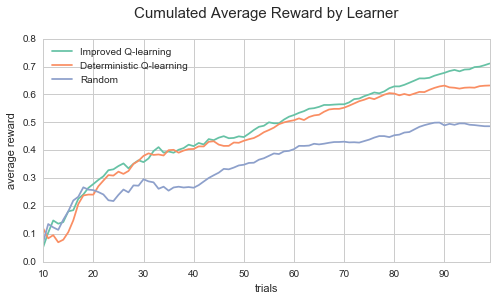

In [18]:
d_rtn = {}
for s_fname, s_key in zip(l_fname, l_agent):
    d2, d3 = eda.performance_measures_gamma(s_fname, s_gamma="1")
    d_rtn[s_key] = d2[1]

ax = pd.DataFrame(d_rtn).ix[10:, l_agent].plot()
ax.set_xlabel("trials")
ax.set_ylabel("average reward")
ax.set_title("Cumulated Average Reward by Learner\n", fontsize=15);

As can be seen above, the improved agent did better than the other implementations. It reached the destination $65\%$ of the trials on time and the final average reward by action was greater than the others. It was achieved by tuning the parameters, including an experimentation strategy and changing the $\hat{Q}$ function to deal with the non-deterministic environment, as explained before. The random agent reached the destination on time just $42\%$ of the trials and the agent that used the deterministic version of $\hat{Q}$ function, $55\%$. Although the final agent is still incurring penalties, it is closer to a perfect agent than it was when using just random moves.

## 7. Reflection

It's hard to say how better would be the performance of a perfect agent to contrast to the current implementation, given the stochastic environment. An option would be to implement a learning agent that already knows the traffic rules and just need to learn how to find his way to the destination on time.

Someting that I learned from reviwers is the importance of the state space

*Style notebook and change matplotlib defaults*

In [7]:
#loading style sheet
from IPython.core.display import HTML
HTML( open('ipython_style.css').read())

In [8]:
#changing matplotlib defaults
%matplotlib inline
import seaborn as sns
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (8, 4)})
sns.set_style("whitegrid")
sns.set_palette(sns.color_palette("Set2", 10))